In [27]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.descent_methods import *
from Code.utilities import MSELoss_method, jax_loss_grad, train_test_split, plot_test_results
from Code.activation_functions import sigmoid

# Import tools from the first project 
from Code.project1_tools import feature_matrix_2d, r2_sampling

import jax.numpy as jnp
from jax import nn
import numpy as np
from matplotlib import pyplot as plt


In [38]:
# Define a neural network
def neural_network(beta, X, activation = sigmoid): # nn.sigmoid??
    out = X.copy()
    for i in range(1, len(beta.keys())//2):
        #print(f'{out.shape} + {beta[f"W{i}"].shape}')

        out = activation(jnp.add(jnp.dot(out, beta[f"W{i}"]), beta[f"b{i}"]))
        
        #out = jnp.dot(out, beta[f"W{i}"])
    out_final = jnp.add(jnp.dot(out, beta[f"W{len(beta.keys())//2}"]), beta[f"b{len(beta.keys())//2}"])
    #print(out.shape)
    return out_final

# Construct beta with desired layer structure
layers = [2 ,20, 20, 1]
beta0 = {}
# Add random initialisation
for i in range(1,len(layers)):
    beta0[f"W{i}"] = np.random.random((layers[i-1], layers[i]))
    beta0[f"b{i}"] = np.random.random()

# Sample points and split in train and test
num_points = 100
data = r2_sampling(num_points, sigma2=0.3)
x, y, z = data["x"], data["y"], data["z"]

# Feature matrix with x and y coordinate of franke function
X = np.array([np.array([x[i][0], y[i][0]]) for i in range(len(x))]) # Have to use [0] since r2_sampling returns list of singleton lists

# Split into train and test and compute minibatch number ...
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2)
m = int(len(y_train) / 10) # Number of of minibatch when using batch size 10
epochs = 50

# Define loss function and gradient
loss_func = MSELoss_method(neural_network)
loss_grad = jax_loss_grad(loss_func)


### Plain GD

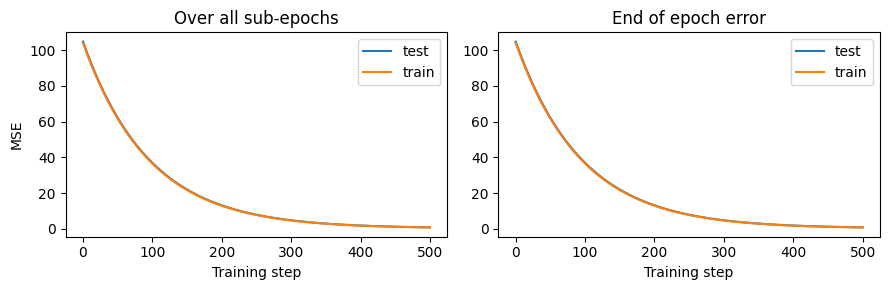

In [29]:
result_GD = GD(X_train, y_train, X_test, y_test, grad_method=loss_grad, n_epochs=epochs*10, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_GD["test_loss_list"], result_GD["train_loss_list"], 1)

### Stochastic

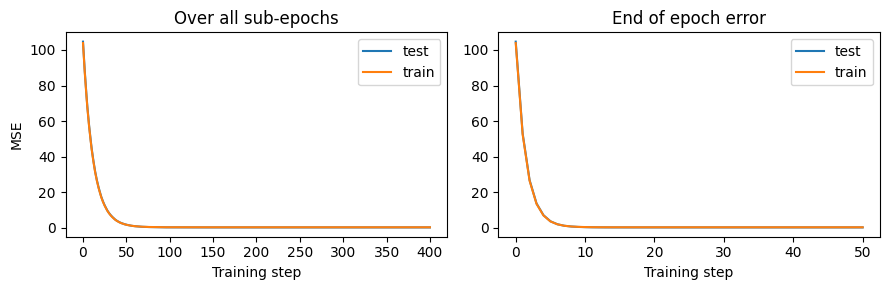

In [30]:
result_SGD = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_SGD["test_loss_list"], result_SGD["train_loss_list"], m)

### Adagrad

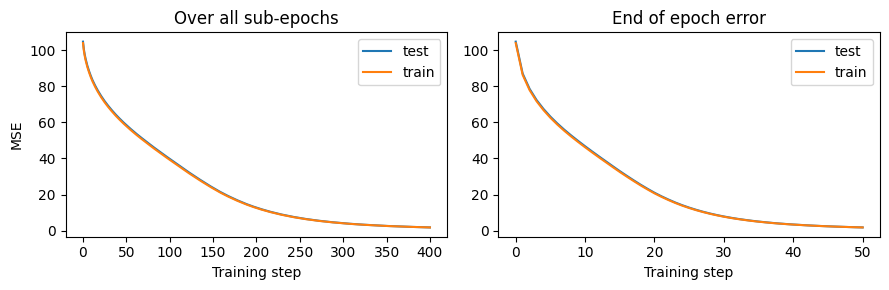

In [31]:
result_adagrad = SGD_adagrad(X_train, y_train, X_test, y_test, grad_method=loss_grad, n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_adagrad["test_loss_list"], result_adagrad["train_loss_list"], m)

### RMS prop

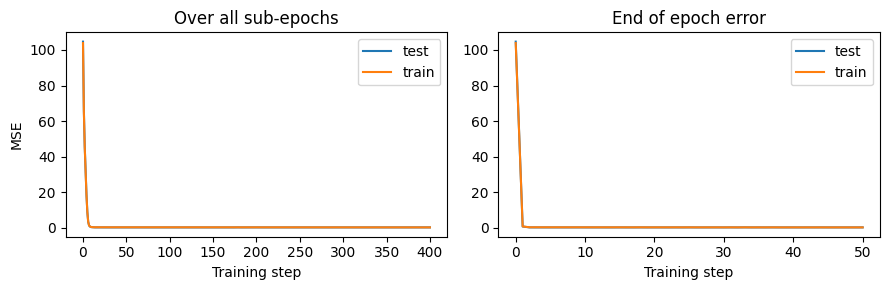

In [32]:
result_RMS_prop = SGD_RMS_prop(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_RMS_prop["test_loss_list"], result_RMS_prop["train_loss_list"], m)

### Adam

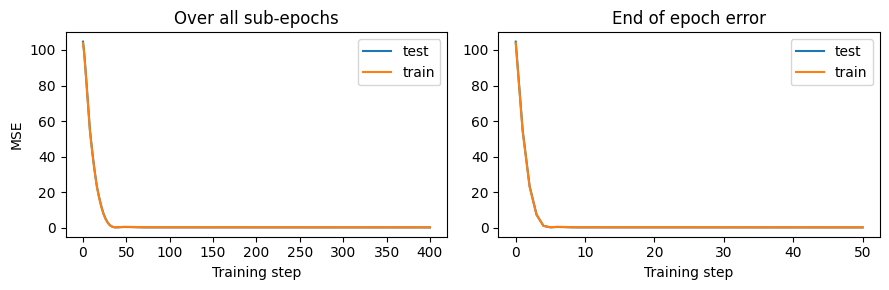

In [33]:
result_adam = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,n_epochs=epochs, beta0=beta0, test_loss_func=loss_func)
plot_test_results(result_adam["test_loss_list"], result_adam["train_loss_list"], m)

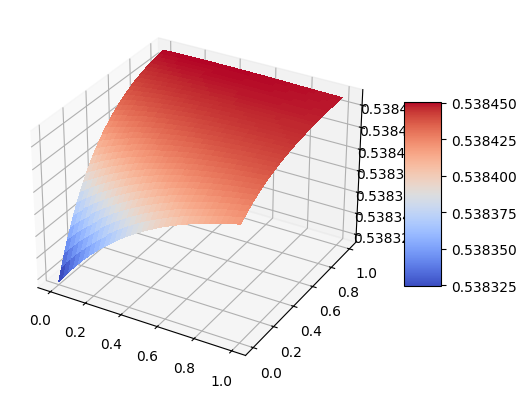

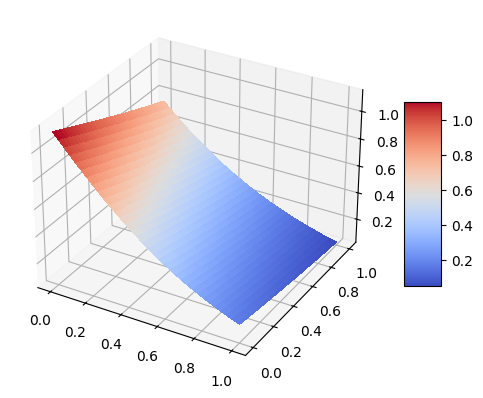

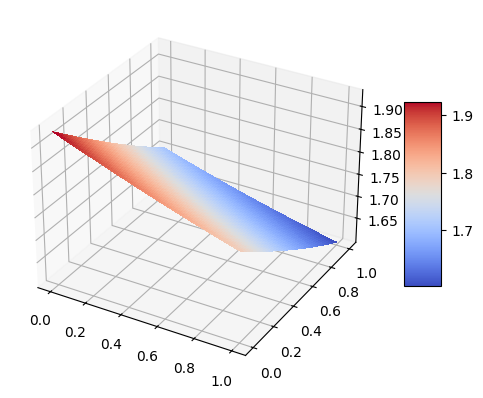

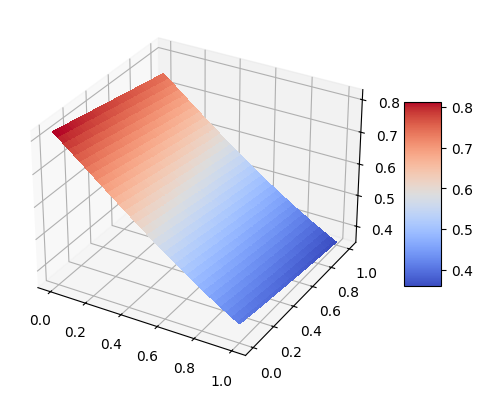

In [36]:

import matplotlib.cm as cm

def plot_surface(x,y,z, filename=None):

    # Init figure
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

    # # Customize the z axis.
    # ax.set_zlim(-0.10, 1.40)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if filename:
        plt.savefig(filename)

    plt.show()

def plot_neural_network_franke_prediction(beta_dict, filename=None):

    # Number of points to use
    num_plot = 101

    # Make data.
    x = np.linspace(0, 1, num_plot).reshape((num_plot, 1))
    y = np.linspace(0, 1, num_plot).reshape((num_plot, 1))

    x_mesh = np.zeros(shape=(num_plot*num_plot, 1))
    y_mesh = np.zeros(shape=(num_plot*num_plot, 1))

    for i in range(num_plot):
        for j in range(num_plot):
            x_mesh[j*num_plot + i] = x[i, 0]
            y_mesh[j*num_plot + i] = y[j, 0]
    
    # Feature matrix of points to plot
    X = np.array([np.array([x[i][0], y[j][0]]) for i in range(len(x)) for j in range(len(y))])
    
    # Make prediction
    z = np.array([s[0] for s in neural_network(beta_dict, X)])

    # Reshaoe
    x_mesh = x_mesh.reshape(num_plot, num_plot)
    y_mesh = y_mesh.reshape(num_plot, num_plot)
    z_mesh = z.reshape(num_plot, num_plot)

    # Plot surface
    plot_surface(x_mesh,y_mesh,z_mesh, filename=filename)



plot_neural_network_franke_prediction(result_SGD["beta_final"])
plot_neural_network_franke_prediction(result_RMS_prop["beta_final"])
plot_neural_network_franke_prediction(result_adagrad["beta_final"])
plot_neural_network_franke_prediction(result_adam["beta_final"])

In [35]:
#